![Py4Eng](../logo.png)

# Transformers
## Yoav Ram

We will see here the [**Transformer** architecture](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)).
Transformers are the basis of large language models like OpenAI's [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer)--the "T" stands for "Transformer".

Here, we apply transformers to timeseries data rather than natural language. 



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

import jax
import keras
print('Keras:', keras.__version__, 'backend:', keras.backend.backend(), jax.default_backend())

Keras: 3.8.0 backend: jax cpu


# Data

The dataset we are using here is called [_FordA_](http://www.j-wichard.de/publications/FordPaper.pdf).
The dataset contains 3,601 training instances and another 1,320 testing instances. So it's not a very big dataset.

Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. 
The goal is to detect the presence of a specific issue with the engine. It is a balanced binary classification task. 

We will use the `FordA_TRAIN` file for training and the `FordA_TEST` file for testing. 
The first column corresponds to the label.

In [3]:
root_url = "https://github.com/yoavram/cd-diagram/raw/master/FordA/"

train_data = np.loadtxt(root_url + "FordA_TRAIN.tsv", delimiter="\t")
x_train, y_train = train_data[:, 1:], train_data[:, 0].astype(int)
test_data = np.loadtxt(root_url + "FordA_TEST.tsv", delimiter="\t")
x_test, y_test = train_data[:, 1:], train_data[:, 0].astype(int)

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
timeseries_length = x_train.shape[1]
print("Good: {}, Bad: {}".format((y_train[:,0]==1).sum(), (y_train[:,0]==0).sum()))
print("Timeseries length:", timeseries_length)

Good: 1846, Bad: 1755
Timeseries length: 500


Here we visualize five example for each class in the dataset.

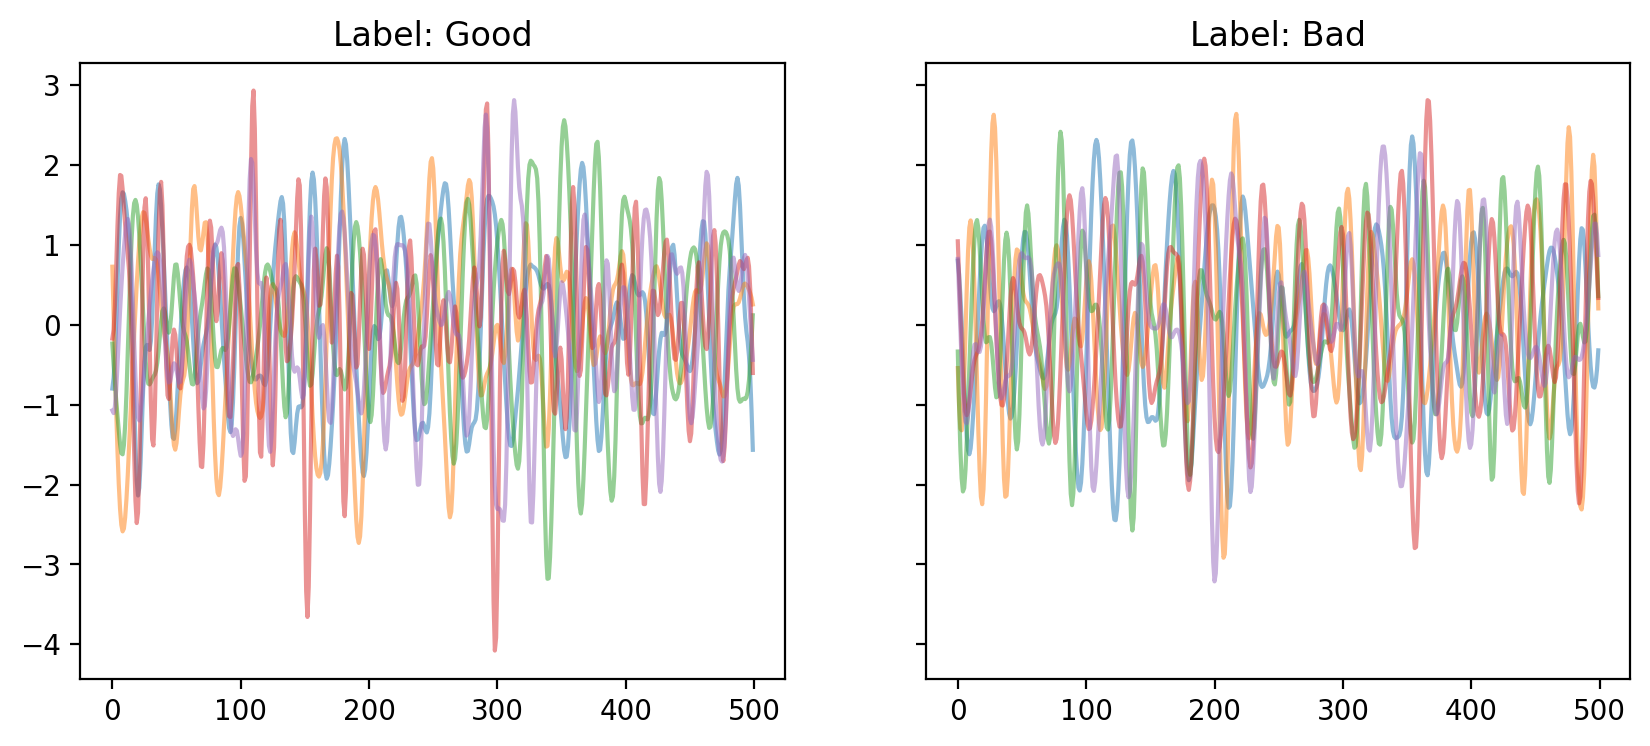

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

x_ = x_train[y_train[:,0]==1]
axes[0].plot(x_[:5].T, alpha=0.5)
axes[0].set_title("Label: Good")

x_ = x_train[y_train[:,1]==1]
axes[1].plot(x_[:5].T, alpha=0.5)
axes[1].set_title("Label: Bad");

We can see that it is not easy to discriminate visually between "good" and "bad" examples.

Note: the data is already scaled (or z-normalized): each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems, see [Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

# Self-attention

Previous recurrent and convolution models that we used had limited access to the input. 
Convolutions could only use nearby elements in the input, and recurrent models had to keep a "memory" or previous elements in the input.

In self-attention, this is solved by computing attention weights for each position in the sequence, such that the attention of element $x_i$ to element $x_j$ is determined by 
$$
q_i = W^q x_i $$$$
k_j = W^k x_j $$$$
w_{ij} = softmax\left(q_i k_j\right)
$$
Here, $q$ stands for _query_ and $k$ stands for _key_.

Then, the output $z_i$ is determined by a
$$
v_j = W^v x_j $$$$
z_i = \sum_j{w_{ij} v_j}
$$
Here, $v$ stands for _value_.
The learnable parameters of self-attention are the matrices $W^q$, $W^k$ and $W^v$.

Multi-head self-attention means that we allow for multiple self-attention models to run in parallel, learning multiple $W^q$, $W^k$ and $W^v$ matrices.
This is similar to allowing for multiple filters or kernels on convolution network. Thus, the multi-head attention layer will output multiple channel.
These channels are then combined using a linear combination, such that the result of the multi-head self-attention layer $z$ is 
$$
z = \sum_{i=1}^m W^o_i z^i
$$
where $z^i$ here is the output of self-attention head $i$ out of $m$, and $W^o$ is a matrice of learnable parameters.

A nice illustration is given in figure 5 of [Ahmed et al. 2022](https://arxiv.org/pdf/2205.01138).

![](multihead_attention.png)


# Transformer classifier

Our model has two parts: 
- a transformer encoder that generates "feautres" or encodes the data to a latent vector,
- and a classifier FFN that uses the generated feautres/latent vector to classify the timeseries.

The input to the transformer has shape `(batch size, timeseries_length, features)`, where `timeseries_length` is the number of time points in te timeseries and `features` is each input timeseries, which in our case is just _one_.

Note that the transformer can replace an RNN: the inputs are fully compatible.

We use [multi-head attention](https://keras.io/api/layers/attention_layers/multi_head_attention/) with  [layer normalization](https://arxiv.org/abs/1607.06450) and dropout.
We then add the input to include residual connections.
The result is then projected using two convolutional layers, again with dropout, normalization, and residual connections.

The resulting layer can be stacked multiple times to make the model deeper.

Note that `MultiHeadAttention` in Keras implements a general attention layer that can take three separate tensors for the `query`, `value`, and `key` tensors. By default `key` equals `value`, and by providing `input` twice we set it to both `query` and `value`, thus implementing self-attention.

In [12]:
def transformer_encoder(input, head_size, num_heads, cnn_dim, dropout_rate=0):
    # Self-Attention: key=query=value=inputs
    x = keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(input, input)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + input

    # Convolution
    x = keras.layers.Conv1D(filters=cnn_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Conv1D(filters=input.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

We will stack several transformer encoders and then use the result as input for a FFN classifier.
Between the encoder and the classifier we need to reduce the output tensor of the encoder down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For this example, a `GlobalAveragePooling1D` layer is sufficient.

In [13]:
def build_model(head_size, num_heads, cnn_dim, num_transformer_blocks, ffn_dims, encoder_dropout=0, ffn_dropout=0):
    inputs = keras.Input(shape=(timeseries_length,))
    inputs = keras.layers.Reshape((timeseries_length, 1))(inputs) # single channel
    # stack of transformer encoders
    x = inputs
    for i in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, cnn_dim, encoder_dropout)
    # pooling
    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    # classifier
    for dim in ffn_dims:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(ffn_dropout)(x)
    outputs = keras.layers.Dense(2, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

Let's stack four transformer encoders and then connect them to the classifier.

In [14]:
model = build_model(
    head_size=256,
    num_heads=4,
    cnn_dim=4,
    num_transformer_blocks=4,
    ffn_dims=[128],
    encoder_dropout=0.25,
    ffn_dropout=0.4
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_9CLONE │ (None, 500, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 1)    │      7,169 │ keras_tensor_9CL… │
│ (MultiHeadAttentio… │                   │            │ keras_tensor_9CL… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 500, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ dropout_4[1][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ keras_tensor_9CL… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 4)    │          8 │ add_1[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 500, 4)    │          0 │ conv1d_1[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 500, 1)    │          5 │ dropout_5[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ conv1d_2[1][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 1)    │      7,169 │ add_2[1][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 500, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ dropout_7[1][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 500, 4)    │          8 │ add_3[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 500, 4)    │          0 │ conv1d_3[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 500, 1)    │          5 │ dropout_8[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ conv1d_4[1][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_3[1][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 93,130 (363.79 KB)

 Trainable params: 93,130 (363.79 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)

We now train the transformer classifier in the same way we did with the CNN classifier.

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
).history

Epoch 1/150
 7/45 ━━━━━━━━━━━━━━━━━━━━ 6:40 11s/step - categorical_accuracy: 0.4877 - loss: 1.0512 

In [ ]:
model.save("../data/ford_transformer.keras")
with open("../data/ford_transformer_history.p", "wb") as f:
    pickle.dump(history, f)

In [ ]:
model = keras.models.load_model("../data/ford_transformer.keras")

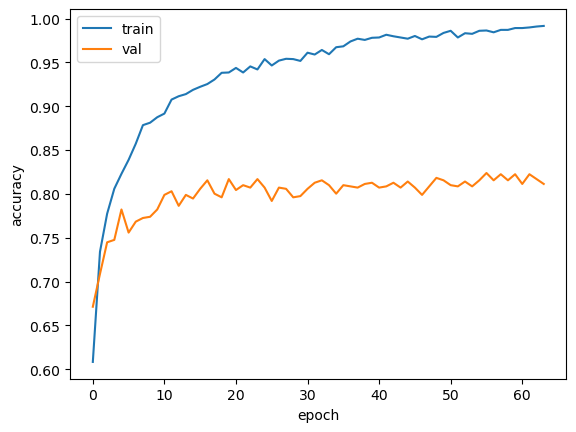

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"]);

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

113/113 [==============================] - 4s 33ms/step - loss: 0.1747 - categorical_accuracy: 0.9478


[0.1747014969587326, 0.9477922916412354]

So, we reached ~94-95% accuracy with this transformer classifier. 

# References
- [Vaswani et al. 2017](http://arxiv.org/abs/1706.03762): _Attention Is All You Need_, the fundamental paper on transformers.
- [Wen et al. 2022](https://arxiv.org/abs/2202.07125): Survey of transformer applications to timeseries data
- [Ahmed et al. 2022](https://arxiv.org/abs/2205.01138): Tutorial on transformers for timeseries data

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)